<a href="https://colab.research.google.com/github/Mahfila/My_Coding_Example_DD/blob/main/BIOACTIVITY3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4848190%2F8187461%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T190341Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D488dd3c8bfb9fd1ce475402f55bc85e64d4ee553e15765e4c48802bc4f7580573ebc0223833bff02fafe4c83ad6f1adfeccb67d0644788b44dae6ef3b1c9f143d4f9ef7b5812010eb19b898d5deffd479d4328f1d1329d062f7099b835a4be22d2b0cd595ccc626333bbcaff395711cf6403c8cb5518ba678c0349b9dee107d11f55e6f5fa653e2308c3a63549611c52034557e4048dfe2c583bc1cf8256988c5a8340331ed3e60cf61bb1a98eee6e9c02eb59af61ecb5a1b5feabb319ece221f5ac53cf4f09c305375e51f970d6875435a924a468048f1226825ddfbe9cca562872466a7d8400d85ecd089071993541893f07aa22ddc51121b94b8447d2eff4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 220337 bytes downloaded
Downloaded and uncompressed: dataset
Data source import complete.


# **Bioinformatics Project - Computational Drug Discovery [Part 3] Descriptor Calculation and Dataset Preparation**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 3**, we will be calculating molecular descriptors that are essentially quantitative description of the compounds in the dataset. Finally, we will be preparing this into a dataset for subsequent model building in Part 4.

---

## **Download PaDEL-Descriptor**

In [2]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2024-04-21 19:07:12--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2024-04-21 19:07:13--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   161MB/s    in 0.2s    

2024-04-21 19:07:13 (161 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2024-04-21 19:07:13--  https://github

In [3]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

## **Load bioactivity data**

Download the curated ChEMBL bioactivity data that has been pre-processed from Parts 1 and 2 of this Bioinformatics Project series. Here we will be using the **bioactivity_data_3class_pIC50.csv** file that essentially contain the pIC50 values that we will be using for building a regression model.

In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv

--2020-06-09 17:00:26--  https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv

Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...

Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 655414 (640K) [text/plain]

Saving to: ‘acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv’



acetylcholinesteras 100%[===================>] 640.05K  --.-KB/s    in 0.07s   



2020-06-09 17:00:26 (9.21 MB/s) - ‘acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv’ saved [655414/655414]




In [4]:
import pandas as pd

In [5]:
df3 = pd.read_csv('/kaggle/input/dataset/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

In [6]:
df3

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,-2.875061
1,1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,-2.000000
2,2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,-4.698970
3,3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,-2.477121
4,4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,-2.903090
...,...,...,...,...,...,...,...,...,...
6364,6364,CHEMBL2238282,O=C(/C=C/c1ccc(N2CCCCC2)cc1)c1sccc1Cl,active,331.868,5.28790,0.0,3.0,-2.204120
6365,6365,CHEMBL4636881,CC(=O)Nc1c(F)cc(C(=O)N[C@H]2CC[C@H](O)CC2)cc1O...,intermediate,414.477,3.95740,3.0,4.0,-3.900000
6366,6366,CHEMBL4635134,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O,inactive,325.368,1.14840,2.0,4.0,-5.000000
6367,6367,CHEMBL4639128,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC[C@H]4CCNC4)cc...,inactive,511.626,5.60034,1.0,8.0,-4.800000


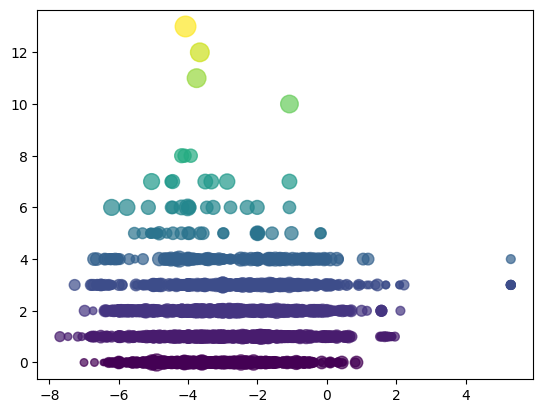

In [16]:
# @title pIC50 vs H-Bond Donors and Acceptors

import matplotlib.pyplot as plt
_ = plt.scatter(df3['pIC50'], df3['NumHDonors'], s=df3['NumHAcceptors']*10, c=df3['NumHDonors'], alpha=0.7)

<Axes: xlabel='MW', ylabel='LogP'>

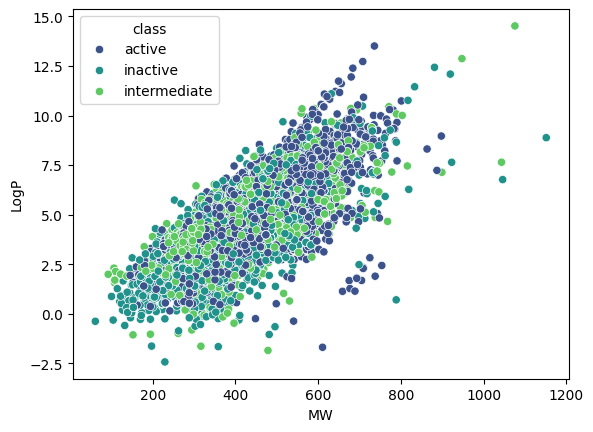

In [15]:
# @title MW vs LogP by class

sns.scatterplot(data=df3, x="MW", y="LogP", hue="class", palette="viridis")

<Axes: xlabel='LogP', ylabel='pIC50'>

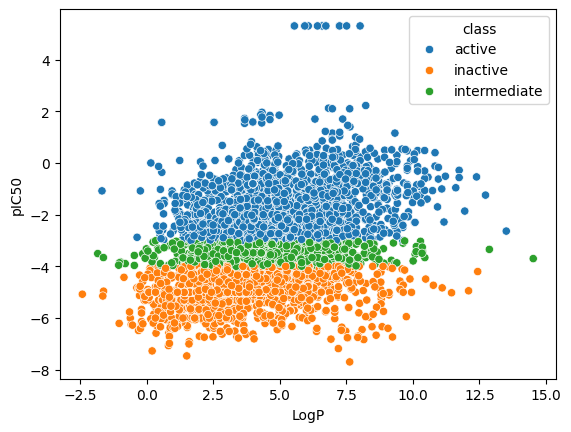

In [14]:
# @title LogP vs pIC50 by Class

sns.scatterplot(data=df3, x="LogP", y="pIC50", hue="class")

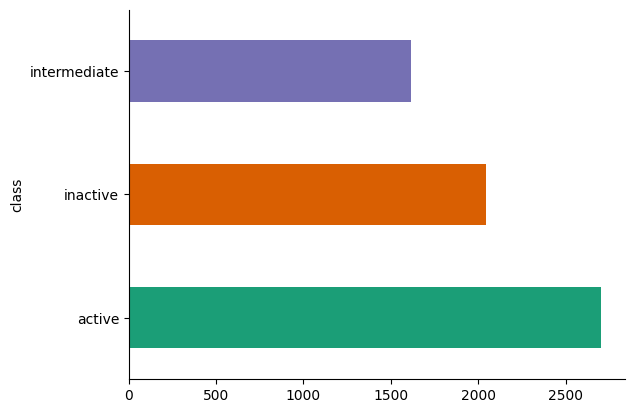

In [13]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
df3.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='LogP', ylabel='pIC50'>

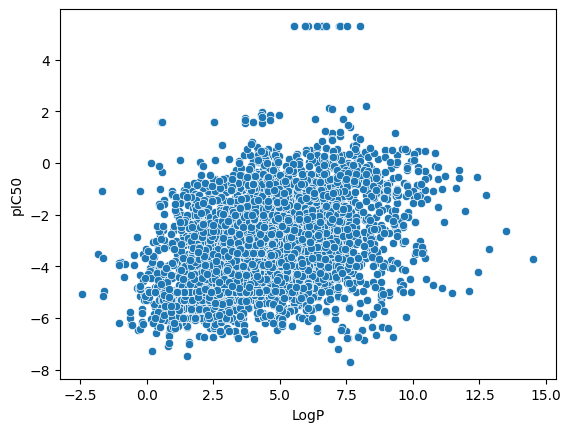

In [12]:
# @title LogP vs pIC50

sns.scatterplot(data=df3, x="LogP", y="pIC50")

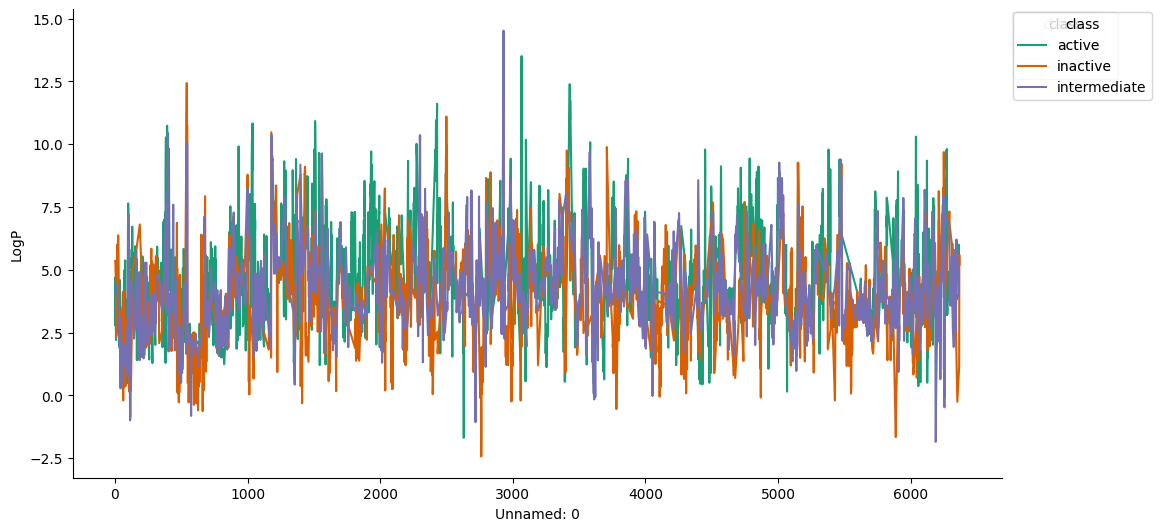

In [11]:
# @title Unnamed: 0 vs LogP

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['LogP']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df3.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('class')):
  _plot_series(series, series_name, i)
  fig.legend(title='class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('LogP')

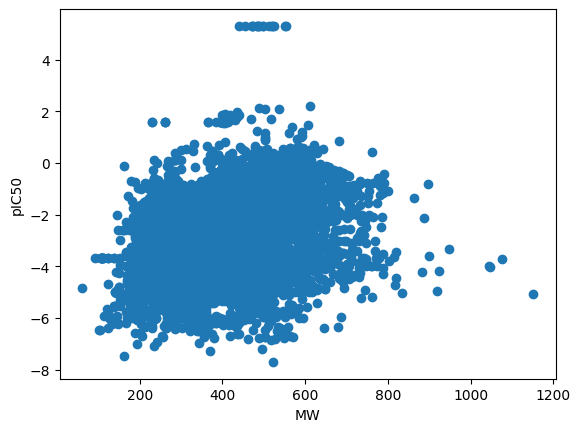

In [10]:
# @title pIC50 vs MW

import matplotlib.pyplot as plt
plt.scatter(df3['MW'], df3['pIC50'])
plt.xlabel('MW')
_ = plt.ylabel('pIC50')

<Axes: xlabel='MW', ylabel='Count'>

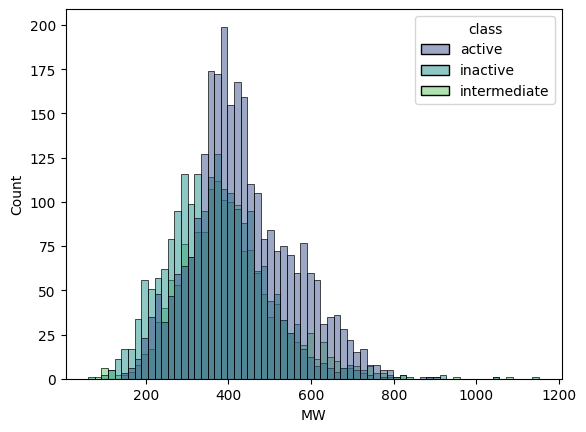

In [9]:
# @title Distribution of MW by Class

sns.histplot(data=df3, x="MW", hue="class", palette="viridis")

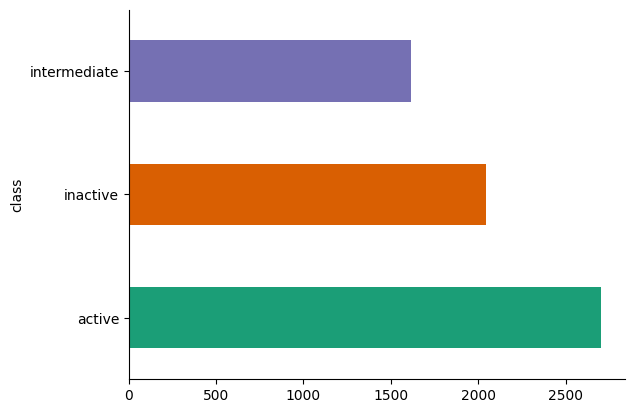

In [8]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
df3.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

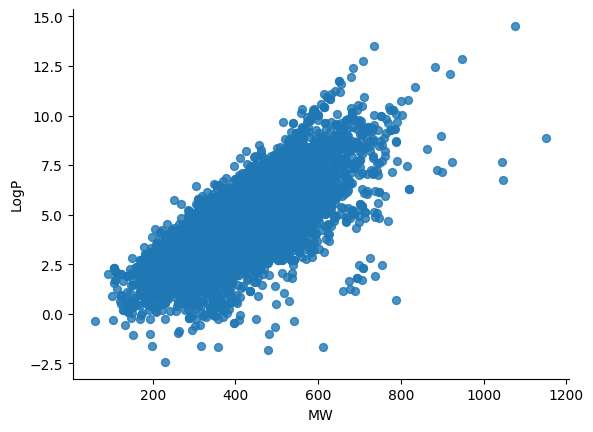

In [7]:
# @title MW vs LogP

from matplotlib import pyplot as plt
df3.plot(kind='scatter', x='MW', y='LogP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478
cat: write error: Broken pipe


In [ ]:
! cat molecule.smi | wc -l

6369


## **Calculate fingerprint descriptors**


### **Calculate PaDEL descriptors**

In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Processing CHEMBL130628 in molecule.smi (4/6369). 
Processing CHEMBL133897 in molecule.smi (1/6369). 
Processing CHEMBL336398 in molecule.smi (2/6369). 
Processing CHEMBL131588 in molecule.smi (3/6369). 
Processing CHEMBL130478 in molecule.smi (5/6369). Average speed: 6.91 s/mol.
Processing CHEMBL130112 in molecule.smi (6/6369). Average speed: 6.93 s/mol.
Processing CHEMBL337486 in molecule.smi (8/6369). Average speed: 1.78 s/mol.
Processing CHEMBL130098 in molecule.smi (7/6369). Average speed: 2.34 s/mol.
Processing CHEMBL336538 in molecule.smi (9/6369). Average speed: 1.48 s/mol.
Processing CHEMBL131051 in molecule.smi (10/6369). Average speed: 1.24 s/mol.
Processing CHEMBL341437 in molecule.smi (11/6369). Average speed: 1.10 s/mol.
Processing CHEMBL335033 in molecule.smi (12/6369). Average speed: 0.97 s/mol.
Processing CHEMBL122983 in molecule.smi (13/6369). Average speed: 0.87 s/mol.
Processing CHEMBL338720 in molecule.smi (14/6369). Average speed: 0.83 s/mol.
Processing CHEMBL3351

In [ ]:
! ls -l

total 36664
drwxrwxr-x 4 root root     4096 May 30  2020 PaDEL-Descriptor
drwxr-xr-x 3 root root     4096 Apr 21 18:39 __MACOSX
-rw-r--r-- 1 root root 11332979 Apr 21 18:56 descriptors_output.csv
-rw-r--r-- 1 root root   424187 Apr 21 18:41 molecule.smi
-rw-r--r-- 1 root root      231 Apr 21 18:39 padel.sh
-rw-r--r-- 1 root root 25768637 Apr 21 18:39 padel.zip


## **Preparing the X and Y Data Matrices**

### **X data matrix**

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')

In [ ]:
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL336398,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL131588,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130098,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364,CHEMBL2238282,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6365,CHEMBL4635134,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6366,CHEMBL4636881,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6367,CHEMBL4639128,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6365,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6366,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6367,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## **Y variable**

### **Convert IC50 to pIC50**

In [ ]:
df3_Y = df3['pIC50']
df3_Y

0      -2.875061
1      -2.000000
2      -4.698970
3      -2.477121
4      -2.903090
          ...   
6364   -2.204120
6365   -3.900000
6366   -5.000000
6367   -4.800000
6368   -4.000000
Name: pIC50, Length: 6369, dtype: float64

## **Combining X and Y variable**

In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-2.875061
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-2.000000
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-4.698970
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-2.477121
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-2.903090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-2.204120
6365,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-3.900000
6366,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-5.000000
6367,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-4.800000


In [ ]:
dataset3.to_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

# **Let's download the CSV file to your local computer for the Part 3B (Model Building).**